# Human vs Machine: Who Detects Phishing Emails Better?

This notebook explores a simple machine learning model that classifies emails as either **phishing** or **legit**, and compares its performance to that of human participants.

We use a small dataset of email examples and train a basic model using `scikit-learn`. The goal is to investigate whether an AI-based tool can outperform students at identifying suspicious emails.


### Step 1: Load the Email Dataset

We begin by importing the dataset (`realistic_emails.csv`) which contains a small collection of real and fake (phishing) emails. Each entry includes:

- `subject`: the email subject line
- `body`: the email message
- `label`: either `phishing` or `legit`


In [227]:
# Step 1: Load the training and test datasets
import pandas as pd
import numpy as np

# Load datasets
train_df = pd.read_csv("train_emails.csv")
test_df = pd.read_csv("test_emails.csv")

# Shuffle the training data
train_df = train_df.sample(frac=1, random_state=np.random.randint(1000))

# Preview the datasets (optional)
print("Training set:")
display(train_df.head())

print("Test set:")
display(test_df.head())

Training set:


,subject,body,label
18,LinkedIn Professional Network: Security Review...,"Dear [User], Our automated security system has...",phishing
20,Bank of America: Security Verification Required,Important: Recent changes to federal banking r...,phishing
34,Mandatory Security Training: 2025 Cybersecurit...,"Dear All Employees, As part of our ongoing com...",legit
22,Re: Q4 Budget Analysis - Updated Projections,"Hey Team, I've updated the Q4 budget spreadshe...",legit
21,System Upgrade Notice: July 20-21,All Users: Critical system upgrades scheduled ...,legit


Test set:


,subject,body,label
0,LinkedIn Professional Network: Security Review...,"Dear [User], Our automated security system has...",phishing
1,Google Workspace Security Alert,Important: A new sign-in was detected on your ...,legit
2,E-ZPass Notice: Outstanding Balance Review,Notice: Our records indicate an unpaid toll ba...,phishing
3,Starbucks Rewards: Your July Member Bonus,Hello Rewards Member! As part of our Summer Ap...,phishing
4,Microsoft 365 Business: Action Required,Your organization's Microsoft 365 Business acc...,legit


### Step 2: Clean and Combine the Text

We now combine the email subject and body into a single field and convert all the text to lowercase.

This makes it easier for the machine learning model to process and identify patterns in the language.


In [228]:
# Step 2: Combine subject + body and lowercase everything

train_df['text'] = (train_df['subject'] + " " + train_df['body']).str.lower()
test_df['text'] = (test_df['subject'] + " " + test_df['body']).str.lower()

# Drop original columns to keep things clean (optional)
train_df = train_df.drop(columns=['subject', 'body'])
test_df = test_df.drop(columns=['subject', 'body'])

# Preview cleaned data
train_df.head()


,label,text
18,phishing,linkedin professional network: security review...
20,phishing,bank of america: security verification require...
34,legit,mandatory security training: 2025 cybersecurit...
22,legit,re: q4 budget analysis - updated projections h...
21,legit,system upgrade notice: july 20-21 all users: c...


### Step 3: Convert Text to Vectors Using TF-IDF

Since machine learning models work with numbers, we use `TfidfVectorizer` to transform each email into a numerical vector. (Term Frequency-Inverse Document Frequency (TF-IDF))

TF-IDF scores give higher weight to uncommon but meaningful words like "verify" or "click", and lower weight to common words like "and" or "the".


In [229]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 3: Create and apply TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# IMPORTANT: fit only on training data
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])  # use the same vectorizer!

# Show the shape of the resulting matrix
print(f"TF-IDF matrix shape: {X_train.shape}")


TF-IDF matrix shape: (42, 1237)


### Step 4: Train the Naive Bayes Classifier

We convert the labels (`phishing`, `legit`) into numbers and split the data into training and test sets.

Then, we train a **Naive Bayes** classifier — a simple, fast model commonly used in spam detection.


In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# Fit the vectorizer only on training data
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common words
    ngram_range=(1, 2),    # Include unigrams and bigrams
)
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])  # Use same vectorizer

# Encode phishing/legit labels as 0/1
le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_test = le.transform(test_df['label'])  # Apply same encoder

# Train the model
modelNB = MultinomialNB(class_prior=[0.5, 0.5])  # Equal weight to phishing and legit
modelNB.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,"[0.5, 0.5]"


### Step 5: Evaluate the Model

We now test the model on unseen emails using several performance metrics:

- **Accuracy**: How many emails it got right overall.
- **Confusion Matrix**: Breakdown of true/false positives/negatives.
- **Precision/Recall**: How well it identifies phishing emails without making too many mistakes.


This model was trained on `train_emails.csv` and evaluated on an unseen file `test_emails.csv`. This simulates real-world behavior and ensures there's no data leakage.


In [231]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set and evaluate
y_pred_nb = modelNB.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb) * 100:.2f}%")

# Confusion Matrix
print("=== Confusion Matrix: ===")
print(confusion_matrix(y_test, y_pred_nb))

# Classification Report
print("\n=== Classification Report: ===")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))


Accuracy: 90.00%
=== Confusion Matrix: ===
[[4 1]
 [0 5]]

=== Classification Report: ===
              precision    recall  f1-score   support

       legit       1.00      0.80      0.89         5
    phishing       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



### Step 6: Compare Different Machine Learning Models

We'll compare three different machine learning approaches for phishing detection:

1. **Naive Bayes (NB)**:
   - Uses probability theory
   - Fast and works well with text

2. **Logistic Regression (LR)**:
   - Linear model that's effective for binary classification (yes or no)
   - Easy to interpret which words influence decisions

3. **Support Vector Machine (SVM)**:
   - Can capture more complex relationships
   - Often performs well in text classification tasks

All models will be:
- Trained on the same TF-IDF vectorized data
- Evaluated using the same metrics 
- Tested on the same unseen test set
- Validated using cross-validation for reliability

This comparison will help us understand which algorithm performs best for phishing detection.

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

# Initialize models with random state
modelLR = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=np.random.randint(1000))
modelSVM = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=np.random.randint(1000))

# Train both models
modelLR.fit(X_train, y_train)
modelSVM.fit(X_train, y_train)

# Get predictions and calculate accuracy
y_pred_lr = modelLR.predict(X_test)
y_pred_svm = modelSVM.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

print("=== Model Accuracies ===")
print(f"Naive Bayes: {acc_nb * 100:.2f}%")
print(f"Logistic Regression: {acc_lr * 100:.2f}%")
print(f"Support Vector Machine: {acc_svm * 100:.2f}%")

# Perform cross-validation with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=np.random.randint(1000))
cv_scores_nb = cross_val_score(modelNB, X_train, y_train, cv=kf)
cv_scores_lr = cross_val_score(modelLR, X_train, y_train, cv=kf)
cv_scores_svm = cross_val_score(modelSVM, X_train, y_train, cv=kf)

print("\n=== Cross-validation Scores ===")
print(f"Naive Bayes: {cv_scores_nb.mean()*100:.2f}% (+/- {cv_scores_nb.std()*2*100:.2f}%)")
print(f"Logistic Regression: {cv_scores_lr.mean()*100:.2f}% (+/- {cv_scores_lr.std()*2*100:.2f}%)")
print(f"Support Vector Machine: {cv_scores_svm.mean()*100:.2f}% (+/- {cv_scores_svm.std()*2*100:.2f}%)")

=== Model Accuracies ===
Naive Bayes: 90.00%
Logistic Regression: 80.00%
Support Vector Machine: 90.00%

=== Cross-validation Scores ===
Naive Bayes: 92.50% (+/- 20.00%)
Logistic Regression: 92.50% (+/- 20.00%)
Support Vector Machine: 90.28% (+/- 18.59%)


### Understanding Cross-Validation

Cross-validation helps us make sure our model's performance is reliable and not just lucky. Here's how it works:

1. The training data is split into 5 parts
2. The model is trained 5 times:
   - Each time using 4 parts for training
   - And 1 part for testing
   - Using a different test part each time

The score format `0.XXX (+/- 0.YYY)` means:
- `0.XXX` is the average accuracy across all 5 tests
- `+/- 0.YYY` shows how much the scores varied
  - Small variation = consistent performance
  - Large variation = unstable performance

This gives us more confidence in our results than a single test score. 

In other words, we are retraining the data with a slightly smaller set and testing it with remaining data in the training set. This is to make sure our test data is not skewed in any way.

### Model Insights and Feature Analysis

Let's analyze which words or phrases our models found most indicative of phishing emails. This can help us understand what patterns the models are learning and compare them with human intuition later.

In [233]:
# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# For Logistic Regression, we can directly get feature importance
lr_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(modelLR.coef_[0])
})
lr_importance = lr_importance.sort_values('importance', ascending=False)

# Display top 10 most important features for phishing detection
print("Top 10 Most Indicative Words/Phrases for Phishing Detection:")
print(lr_importance.head(10).to_string(index=False))

Top 10 Most Indicative Words/Phrases for Phishing Detection:
     feature  importance
    security    0.566731
     account    0.555857
verification    0.430509
         xxx    0.347129
     project    0.297847
      verify    0.291224
    planning    0.281529
        week    0.264548
      paypal    0.258985
    linkedin    0.243856


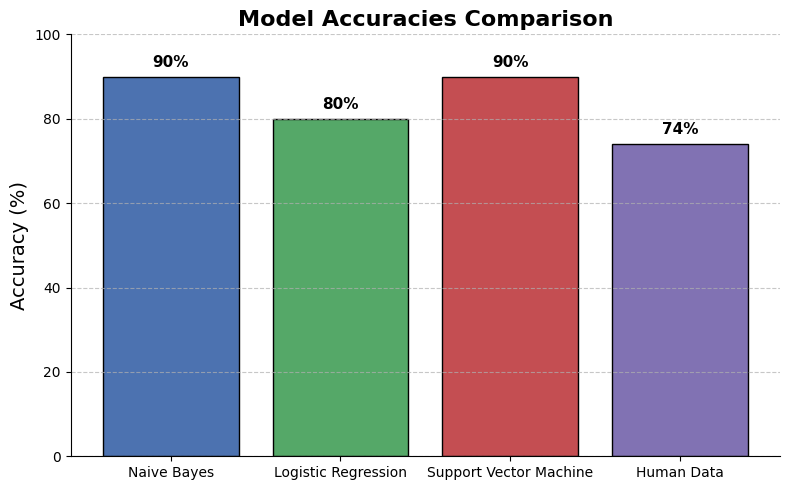

In [234]:
import matplotlib.pyplot as plt

# Data
models = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machine', 'Human Data']
accuracies = [90, 80, 90, 74]

# Colors for bars
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3']

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(models, accuracies, color=colors, edgecolor='black')

# Add accuracy labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=11,
                fontweight='bold')

# Title and labels
ax.set_title('Model Accuracies Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_ylim(0, 100)

# Gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
